In [1]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 16384 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "codellama/CodeLlama-13b-Instruct-hf",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!


/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


INFO 06-09 12:32:43 [importing.py:53] Triton module has been replaced with a placeholder.


INFO 06-09 12:32:43 [__init__.py:239] Automatically detected platform cuda.


2025-06-09 12:32:45,325	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


==((====))==  Unsloth 2025.5.3: Fast Llama patching. Transformers: 4.51.3. vLLM: 0.8.5.
   \\   /|    Tesla V100-SXM2-32GB. Num GPUs = 1. Max memory: 31.749 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!



Loading checkpoint shards:   0%|                                                                     | 0/3 [00:00<?, ?it/s]


Loading checkpoint shards:  33%|████████████████████▎                                        | 1/3 [00:11<00:23, 11.54s/it]


Loading checkpoint shards:  67%|████████████████████████████████████████▋                    | 2/3 [00:21<00:10, 10.81s/it]


Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████| 3/3 [00:28<00:00,  8.70s/it]


Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████| 3/3 [00:28<00:00,  9.34s/it]

codellama/CodeLlama-13b-Instruct-hf does not have a padding token! Will use pad_token = <unk>.


In [ ]:
lora_rank = 64

model = FastLanguageModel.get_peft_model(
    model,
    r = lora_rank, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = lora_rank,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 42,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.5.3 patched 40 layers with 40 QKV layers, 40 O layers and 40 MLP layers.


In [ ]:
from datasets import load_dataset

# Define the paths to your dataset files
data_files = {
    'train': 'severity_data_train.csv',
    'val': 'severity_data_val.csv',
    'test': 'severity_data_test.csv'
}

# Load the dataset
dataset = load_dataset('csv', data_files=data_files)

In [4]:
import random
from datasets import concatenate_datasets, DatasetDict

random.seed(42)

SYSTEM_PROMPT = [
    """You are the smartest AI solidity smart contract security auditor in the world that only answer in one word between "low", "medium" or "high".""",
]

PROMPTS = [
    """You need to analyze the given vulnerability explanation and classify the severity of it as "low", "medium" or "high" based on the impact of that vulnerability. Dont give any additional explanations just give the label (low, medium or high).
    
    This is the vulnerability explanation we need to analyze:
    {explanation}
    
Answer: """,
]

def make_conversational(examples, system_prompt, prompt):
    explanation = examples['vuln_explanation']
    severity = examples['severity']
    selected_system_prompt = system_prompt
    selected_user_prompt = prompt
    conversation = [{"role": "system", "content": selected_system_prompt}, 
                    {"role": "user", "content": selected_user_prompt.format(explanation=explanation)},
                    {"role": "assistant", "content": severity}]
    
    return { "conversations" : conversation}

# List of splits you want to process
splits = ['train', 'val', 'test']

# Dictionary to store concatenated datasets for each split
concatenated_datasets = {split: [] for split in splits}

# Process each dataset
for i in range(len(PROMPTS)):
    system_prompt = SYSTEM_PROMPT[i]
    prompt = PROMPTS[i]
    
    # Create a new dataset using map
    new_dataset = dataset.map(lambda ex: make_conversational(ex, system_prompt, prompt))
    
    # Append the correct split of the new dataset to the corresponding list
    for split in splits:
        concatenated_datasets[split].append(new_dataset[split])

# Now concatenate all datasets for each split
dataset = DatasetDict({
    split: concatenate_datasets(concatenated_datasets[split]).shuffle(seed=42) for split in splits
})

dataset = dataset.remove_columns(["file_name", "vuln_title", "vuln_explanation", "vuln_recommendation", "vuln_code"])


Map:   0%|                                                                                  | 0/662 [00:00<?, ? examples/s]


Map: 100%|██████████████████████████████████████████████████████████████████████| 662/662 [00:00<00:00, 5750.33 examples/s]


Map: 100%|██████████████████████████████████████████████████████████████████████| 662/662 [00:00<00:00, 5587.30 examples/s]


Map:   0%|                                                                                  | 0/142 [00:00<?, ? examples/s]


Map: 100%|██████████████████████████████████████████████████████████████████████| 142/142 [00:00<00:00, 5022.27 examples/s]


Map:   0%|                                                                                  | 0/143 [00:00<?, ? examples/s]


Map: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:00<00:00, 5149.79 examples/s]

In [5]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama",
)

def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }

dataset = dataset.map(formatting_prompts_func, batched = True,)


Map:   0%|                                                                                  | 0/662 [00:00<?, ? examples/s]


Map: 100%|██████████████████████████████████████████████████████████████████████| 662/662 [00:00<00:00, 6017.60 examples/s]


Map: 100%|██████████████████████████████████████████████████████████████████████| 662/662 [00:00<00:00, 5797.27 examples/s]


Map:   0%|                                                                                  | 0/142 [00:00<?, ? examples/s]


Map: 100%|██████████████████████████████████████████████████████████████████████| 142/142 [00:00<00:00, 5977.49 examples/s]


Map:   0%|                                                                                  | 0/143 [00:00<?, ? examples/s]


Map: 100%|██████████████████████████████████████████████████████████████████████| 143/143 [00:00<00:00, 5325.60 examples/s]

In [6]:
dataset['train'][5]["conversations"]

[{'content': 'You are the smartest AI solidity smart contract security auditor in the world that only answer in one word between "low", "medium" or "high".',
  'role': 'system'},
 {'content': 'You need to analyze the given vulnerability explanation and classify the severity of it as "low", "medium" or "high" based on the impact of that vulnerability. Dont give any additional explanations just give the label (low, medium or high).\n    \n    This is the vulnerability explanation we need to analyze:\n    In `VaderPoolV2.burn` we calculate the current losses that the LP has made to impermanent loss.\n\nThese losses are then refunded to the LP in VADER tokens from the reserve. NOTE: This IL protection is paid for ALL token pairs. THIS IS IMPORTANT!\n\nThe loss is calculated by the comparing the amounts of each asset initially added to the pool against the amounts of each asset which are removed from the pool. There\'s an unspoken assumption here that the LP entered the pool at the true pri

In [7]:
dataset['train'][5]["text"]

'<s>[INST] <<SYS>>\nYou are the smartest AI solidity smart contract security auditor in the world that only answer in one word between "low", "medium" or "high".\n<</SYS>>\n\nYou need to analyze the given vulnerability explanation and classify the severity of it as "low", "medium" or "high" based on the impact of that vulnerability. Dont give any additional explanations just give the label (low, medium or high).\n    \n    This is the vulnerability explanation we need to analyze:\n    In `VaderPoolV2.burn` we calculate the current losses that the LP has made to impermanent loss.\n\nThese losses are then refunded to the LP in VADER tokens from the reserve. NOTE: This IL protection is paid for ALL token pairs. THIS IS IMPORTANT!\n\nThe loss is calculated by the comparing the amounts of each asset initially added to the pool against the amounts of each asset which are removed from the pool. There\'s an unspoken assumption here that the LP entered the pool at the true price at that point.\

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

train_dataset = dataset['train']
val_dataset = dataset['val']

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 4,
    packing = False, 
    args = TrainingArguments(
        eval_strategy="steps",
        eval_steps=100,
        save_steps=200,
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 8, 
        warmup_ratio = 0.1,
        num_train_epochs = 5, 
        learning_rate = 2e-5,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit", 
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        load_best_model_at_end=True,
        output_dir = "outputs_codellama_severity",
        report_to = "none", 
    ),
)


Unsloth: Tokenizing ["text"] (num_proc=4):   0%|                                            | 0/662 [00:00<?, ? examples/s]


Unsloth: Tokenizing ["text"] (num_proc=4):  25%|████████▎                        | 166/662 [00:00<00:01, 376.06 examples/s]


Unsloth: Tokenizing ["text"] (num_proc=4): 100%|████████████████████████████████| 662/662 [00:00<00:00, 1441.04 examples/s]


Unsloth: Tokenizing ["text"] (num_proc=4): 100%|████████████████████████████████| 662/662 [00:00<00:00, 1015.81 examples/s]


Unsloth: Tokenizing ["text"] (num_proc=4):   0%|                                            | 0/142 [00:00<?, ? examples/s]


Unsloth: Tokenizing ["text"] (num_proc=4):  25%|████████▌                         | 36/142 [00:00<00:00, 119.29 examples/s]


Unsloth: Tokenizing ["text"] (num_proc=4): 100%|█████████████████████████████████| 142/142 [00:00<00:00, 290.34 examples/s]

Detected kernel version 4.15.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [9]:
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<</SYS>>\n\n",
    response_part = "[/INST]",
)


Map (num_proc=80):   0%|                                                                    | 0/662 [00:00<?, ? examples/s]


Map (num_proc=80):   1%|▊                                                           | 9/662 [00:00<00:08, 78.22 examples/s]


Map (num_proc=80):   8%|████▋                                                     | 54/662 [00:00<00:03, 156.60 examples/s]


Map (num_proc=80):  12%|███████                                                   | 81/662 [00:00<00:03, 156.24 examples/s]


Map (num_proc=80):  18%|██████████                                               | 117/662 [00:00<00:02, 184.29 examples/s]


Map (num_proc=80):  54%|██████████████████████████████▊                          | 358/662 [00:00<00:00, 727.81 examples/s]


Map (num_proc=80):  96%|█████████████████████████████████████████████████████▉  | 638/662 [00:00<00:00, 1235.62 examples/s]


Map (num_proc=80): 100%|█████████████████████████████████████████████████████████| 662/662 [00:01<00:00, 659.36 examples/s]


Map (num_proc=80):   0%|                                                                    | 0/142 [00:00<?, ? examples/s]


Map (num_proc=80):   1%|▊                                                           | 2/142 [00:00<00:09, 14.97 examples/s]


Map (num_proc=80):   4%|██▌                                                         | 6/142 [00:00<00:05, 23.83 examples/s]


Map (num_proc=80):  10%|█████▊                                                     | 14/142 [00:00<00:04, 31.00 examples/s]


Map (num_proc=80):  14%|████████▎                                                  | 20/142 [00:00<00:03, 38.48 examples/s]


Map (num_proc=80):  55%|███████████████████████████████▊                          | 78/142 [00:00<00:00, 187.60 examples/s]


Map (num_proc=80):  96%|██████████████████████████████████████████████████████▌  | 136/142 [00:00<00:00, 296.10 examples/s]


Map (num_proc=80): 100%|█████████████████████████████████████████████████████████| 142/142 [00:00<00:00, 156.58 examples/s]

In [10]:
tokenizer.decode(trainer.train_dataset[5]["input_ids"])

'<s><s> [INST] <<SYS>>\nYou are the smartest AI solidity smart contract security auditor in the world that only answer in one word between "low", "medium" or "high".\n<</SYS>>\n\nYou need to analyze the given vulnerability explanation and classify the severity of it as "low", "medium" or "high" based on the impact of that vulnerability. Dont give any additional explanations just give the label (low, medium or high).\n    \n    This is the vulnerability explanation we need to analyze:\n    In `VaderPoolV2.burn` we calculate the current losses that the LP has made to impermanent loss.\n\nThese losses are then refunded to the LP in VADER tokens from the reserve. NOTE: This IL protection is paid for ALL token pairs. THIS IS IMPORTANT!\n\nThe loss is calculated by the comparing the amounts of each asset initially added to the pool against the amounts of each asset which are removed from the pool. There\'s an unspoken assumption here that the LP entered the pool at the true price at that poi

In [11]:
space = tokenizer(" ", add_special_tokens = False).input_ids[0]
tokenizer.decode([space if x == -100 else x for x in trainer.train_dataset[5]["labels"]])

'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [12]:
tokenizer.decode(trainer.eval_dataset[5]["input_ids"])

'<s><s> [INST] <<SYS>>\nYou are the smartest AI solidity smart contract security auditor in the world that only answer in one word between "low", "medium" or "high".\n<</SYS>>\n\nYou need to analyze the given vulnerability explanation and classify the severity of it as "low", "medium" or "high" based on the impact of that vulnerability. Dont give any additional explanations just give the label (low, medium or high).\n    \n    This is the vulnerability explanation we need to analyze:\n    As the return value of `ERC1155.balanceOf` was changed to a signed integer, the `nERC1155Interface` does not implement the `ERC1155` interface and the `supportsInterface` call will return false if people call it with the actual `ERC1155` interface ID.\n\nNot all users of the contract might care about the `balance` function and call `supportsInterface` with the original EIP1155 interface.\nThe contract will still deny the *[content missing]*\n\nIt is indeed debatable if this contract should be consider

In [13]:
space = tokenizer(" ", add_special_tokens = False).input_ids[0]
tokenizer.decode([space if x == -100 else x for x in trainer.eval_dataset[5]["labels"]])

'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        low </s>'

In [14]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 662 | Num Epochs = 5 | Total steps = 410
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 8 x 1) = 8
 "-____-"     Trainable parameters = 250,347,520/13,000,000,000 (1.93% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
100,0.336100,0.303028
200,0.287500,0.328543
300,0.080100,0.321933
400,0.276900,0.312353


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


In [ ]:
from datasets import load_dataset

# Define the paths to your dataset files
data_files = {
    'train': 'severity_data_train.csv',
    'val': 'severity_data_val.csv',
    'test': 'severity_data_test.csv'
}

# Load the dataset
dataset = load_dataset('csv', data_files=data_files)

import random
from datasets import concatenate_datasets, DatasetDict

random.seed(42)

SYSTEM_PROMPT = [
    """You are the smartest AI solidity smart contract security auditor in the world that only answer in one word between "low", "medium" or "high".""",
]

PROMPTS = [
    """You need to analyze the given vulnerability explanation and classify the severity of it as "low", "medium" or "high" based on the impact of that vulnerability. Dont give any additional explanations just give the label (low, medium or high).
    
    This is the vulnerability explanation we need to analyze:
    {explanation}
    
Answer: """,
]

def make_conversational_vote(examples, system_prompt, prompt):
    explanation = examples['vuln_explanation']
    severity = examples['severity']
    selected_system_prompt = system_prompt
    selected_user_prompt = prompt
    conversation = [{"role": "system", "content": selected_system_prompt}, 
                    {"role": "user", "content": selected_user_prompt.format(explanation=explanation)}]
    
    return { "conversations" : conversation, 'label': severity}

# Generate 5 datasets using different prompts
datasets = []
for i in range(len(PROMPTS)):
    new_dataset = dataset.map(lambda ex: make_conversational_vote(ex, SYSTEM_PROMPT[i], PROMPTS[i]))
    new_dataset = new_dataset.remove_columns(["file_name", "vuln_title", "vuln_explanation", "vuln_recommendation", "vuln_code"])
    datasets.append(new_dataset)
    
test_dataset = datasets[0]['test']

In [16]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama",
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = test_dataset['conversations'][1]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

outputs = model.generate(input_ids = inputs, max_new_tokens = 64, use_cache = True,
                         temperature = 1.5, min_p = 0.1)
tokenizer.batch_decode(outputs)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


['<s> [INST] <<SYS>>\nYou are the smartest AI solidity smart contract security auditor in the world that only answer in one word between "low", "medium" or "high".\n<</SYS>>\n\nYou need to analyze the given vulnerability explanation and classify the severity of it as "low", "medium" or "high" based on the impact of that vulnerability. Dont give any additional explanations just give the label (low, medium or high).\n    \n    This is the vulnerability explanation we need to analyze:\n    If an oracle price falls out of the valid min/max range, the `citadelPriceFlag` is set to true, but the out-of-bounds value is not stored. If the policy operations team calls `clearCitadelPriceFlag()`, the stale price from before the flag will be used. Not only is it an issue because of stale prices, but this means the policy op team now has a way to affect pricing not under the control of the oracle (i.e. no unusual coordination required to affect an outcome). Incorrect pricing leads to incorrect asset

In [17]:
from unsloth.chat_templates import get_chat_template
from tqdm import tqdm
import re

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama",
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

# Define regex pattern to extract the assistant's response
pattern = r"\[/INST](.*?)</s>"

y_pred = []

for messages in tqdm(test_dataset['conversations']):
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize = True,
        add_generation_prompt = True, # Must add for generation
        return_tensors = "pt",
    ).to("cuda")

    outputs = model.generate(input_ids = inputs, max_new_tokens = 64, use_cache = True,
                             temperature = 0.6, min_p = 0.1)
    decoded_output = tokenizer.batch_decode(outputs)[0]
    
    # Extract the label using regex
    match = re.search(pattern, decoded_output, re.DOTALL)
    extracted_label = match.group(1).strip() if match else "Unknown"

    # Append the extracted label
    y_pred.append(extracted_label)


  0%|                                                                                              | 0/143 [00:00<?, ?it/s]


  1%|▌                                                                                     | 1/143 [00:00<01:12,  1.96it/s]


  1%|█▏                                                                                    | 2/143 [00:00<01:08,  2.07it/s]


  2%|█▊                                                                                    | 3/143 [00:01<01:07,  2.06it/s]


  3%|██▍                                                                                   | 4/143 [00:01<01:07,  2.07it/s]


  3%|███                                                                                   | 5/143 [00:02<01:05,  2.10it/s]


  4%|███▌                                                                                  | 6/143 [00:02<01:05,  2.08it/s]


  5%|████▏                                                                                 | 7/143 [00:03<01:05,  2.09it/s]


  6%|████▊                                                                                 | 8/143 [00:03<01:05,  2.06it/s]


  6%|█████▍                                                                                | 9/143 [00:04<01:02,  2.15it/s]


  7%|█████▉                                                                               | 10/143 [00:04<01:02,  2.13it/s]


  8%|██████▌                                                                              | 11/143 [00:05<01:00,  2.20it/s]


  8%|███████▏                                                                             | 12/143 [00:05<01:00,  2.18it/s]


  9%|███████▋                                                                             | 13/143 [00:06<01:00,  2.14it/s]


 10%|████████▎                                                                            | 14/143 [00:06<00:58,  2.19it/s]


 10%|████████▉                                                                            | 15/143 [00:07<00:58,  2.18it/s]


 11%|█████████▌                                                                           | 16/143 [00:07<00:59,  2.14it/s]


 12%|██████████                                                                           | 17/143 [00:08<00:59,  2.10it/s]


 13%|██████████▋                                                                          | 18/143 [00:08<01:06,  1.88it/s]


 13%|███████████▎                                                                         | 19/143 [00:09<01:05,  1.89it/s]


 14%|███████████▉                                                                         | 20/143 [00:09<01:04,  1.92it/s]


 15%|████████████▍                                                                        | 21/143 [00:10<01:05,  1.86it/s]


 15%|█████████████                                                                        | 22/143 [00:10<01:02,  1.93it/s]


 16%|█████████████▋                                                                       | 23/143 [00:11<00:58,  2.05it/s]


 17%|██████████████▎                                                                      | 24/143 [00:11<00:57,  2.06it/s]


 17%|██████████████▊                                                                      | 25/143 [00:12<00:55,  2.14it/s]


 18%|███████████████▍                                                                     | 26/143 [00:12<00:53,  2.21it/s]


 19%|████████████████                                                                     | 27/143 [00:13<01:03,  1.84it/s]


 20%|████████████████▋                                                                    | 28/143 [00:13<01:01,  1.88it/s]


 20%|█████████████████▏                                                                   | 29/143 [00:14<00:58,  1.94it/s]


 21%|█████████████████▊                                                                   | 30/143 [00:14<00:58,  1.94it/s]


 22%|██████████████████▍                                                                  | 31/143 [00:15<00:59,  1.88it/s]


 22%|███████████████████                                                                  | 32/143 [00:15<00:56,  1.95it/s]


 23%|███████████████████▌                                                                 | 33/143 [00:16<00:53,  2.07it/s]


 24%|████████████████████▏                                                                | 34/143 [00:16<00:53,  2.05it/s]


 24%|████████████████████▊                                                                | 35/143 [00:17<00:55,  1.96it/s]


 25%|█████████████████████▍                                                               | 36/143 [00:17<00:53,  2.00it/s]


 26%|█████████████████████▉                                                               | 37/143 [00:18<00:52,  2.02it/s]


 27%|██████████████████████▌                                                              | 38/143 [00:18<00:51,  2.03it/s]


 27%|███████████████████████▏                                                             | 39/143 [00:19<00:49,  2.12it/s]


 28%|███████████████████████▊                                                             | 40/143 [00:19<00:47,  2.19it/s]


 29%|████████████████████████▎                                                            | 41/143 [00:20<00:47,  2.15it/s]


 29%|████████████████████████▉                                                            | 42/143 [00:20<00:45,  2.21it/s]


 30%|█████████████████████████▌                                                           | 43/143 [00:21<00:51,  1.94it/s]


 31%|██████████████████████████▏                                                          | 44/143 [00:21<00:48,  2.04it/s]


 31%|██████████████████████████▋                                                          | 45/143 [00:22<00:48,  2.04it/s]


 32%|███████████████████████████▎                                                         | 46/143 [00:22<00:45,  2.13it/s]


 33%|███████████████████████████▉                                                         | 47/143 [00:22<00:45,  2.11it/s]


 34%|████████████████████████████▌                                                        | 48/143 [00:23<00:45,  2.11it/s]


 34%|█████████████████████████████▏                                                       | 49/143 [00:23<00:43,  2.17it/s]


 35%|█████████████████████████████▋                                                       | 50/143 [00:24<00:42,  2.21it/s]


 36%|██████████████████████████████▎                                                      | 51/143 [00:24<00:42,  2.18it/s]


 36%|██████████████████████████████▉                                                      | 52/143 [00:25<00:42,  2.15it/s]


 37%|███████████████████████████████▌                                                     | 53/143 [00:25<00:42,  2.12it/s]


 38%|████████████████████████████████                                                     | 54/143 [00:26<00:40,  2.19it/s]


 38%|████████████████████████████████▋                                                    | 55/143 [00:26<00:40,  2.15it/s]


 39%|█████████████████████████████████▎                                                   | 56/143 [00:27<00:40,  2.14it/s]


 40%|█████████████████████████████████▉                                                   | 57/143 [00:27<00:40,  2.11it/s]


 41%|██████████████████████████████████▍                                                  | 58/143 [00:28<00:40,  2.07it/s]


 41%|███████████████████████████████████                                                  | 59/143 [00:28<00:40,  2.09it/s]


 42%|███████████████████████████████████▋                                                 | 60/143 [00:29<00:39,  2.08it/s]


 43%|████████████████████████████████████▎                                                | 61/143 [00:29<00:41,  1.97it/s]


 43%|████████████████████████████████████▊                                                | 62/143 [00:30<00:40,  1.99it/s]


 44%|█████████████████████████████████████▍                                               | 63/143 [00:30<00:41,  1.91it/s]


 45%|██████████████████████████████████████                                               | 64/143 [00:31<00:39,  2.02it/s]


 45%|██████████████████████████████████████▋                                              | 65/143 [00:31<00:38,  2.05it/s]


 46%|███████████████████████████████████████▏                                             | 66/143 [00:32<00:37,  2.04it/s]


 47%|███████████████████████████████████████▊                                             | 67/143 [00:32<00:38,  1.95it/s]


 48%|████████████████████████████████████████▍                                            | 68/143 [00:33<00:37,  2.00it/s]


 48%|█████████████████████████████████████████                                            | 69/143 [00:33<00:36,  2.04it/s]


 49%|█████████████████████████████████████████▌                                           | 70/143 [00:34<00:38,  1.87it/s]


 50%|██████████████████████████████████████████▏                                          | 71/143 [00:34<00:37,  1.92it/s]


 50%|██████████████████████████████████████████▊                                          | 72/143 [00:35<00:40,  1.76it/s]


 51%|███████████████████████████████████████████▍                                         | 73/143 [00:35<00:38,  1.84it/s]


 52%|███████████████████████████████████████████▉                                         | 74/143 [00:36<00:35,  1.92it/s]


 52%|████████████████████████████████████████████▌                                        | 75/143 [00:36<00:34,  1.97it/s]


 53%|█████████████████████████████████████████████▏                                       | 76/143 [00:37<00:33,  1.98it/s]


 54%|█████████████████████████████████████████████▊                                       | 77/143 [00:37<00:32,  2.03it/s]


 55%|██████████████████████████████████████████████▎                                      | 78/143 [00:38<00:31,  2.06it/s]


 55%|██████████████████████████████████████████████▉                                      | 79/143 [00:38<00:31,  2.05it/s]


 56%|███████████████████████████████████████████████▌                                     | 80/143 [00:39<00:33,  1.89it/s]


 57%|████████████████████████████████████████████████▏                                    | 81/143 [00:39<00:32,  1.92it/s]


 57%|████████████████████████████████████████████████▋                                    | 82/143 [00:40<00:33,  1.80it/s]


 58%|█████████████████████████████████████████████████▎                                   | 83/143 [00:41<00:33,  1.79it/s]


 59%|█████████████████████████████████████████████████▉                                   | 84/143 [00:41<00:33,  1.78it/s]


 59%|██████████████████████████████████████████████████▌                                  | 85/143 [00:42<00:30,  1.91it/s]


 60%|███████████████████████████████████████████████████                                  | 86/143 [00:42<00:28,  1.98it/s]


 61%|███████████████████████████████████████████████████▋                                 | 87/143 [00:43<00:27,  2.01it/s]


 62%|████████████████████████████████████████████████████▎                                | 88/143 [00:43<00:27,  2.02it/s]


 62%|████████████████████████████████████████████████████▉                                | 89/143 [00:43<00:25,  2.11it/s]


 63%|█████████████████████████████████████████████████████▍                               | 90/143 [00:44<00:25,  2.11it/s]


 64%|██████████████████████████████████████████████████████                               | 91/143 [00:44<00:23,  2.18it/s]


 64%|██████████████████████████████████████████████████████▋                              | 92/143 [00:45<00:23,  2.21it/s]


 65%|███████████████████████████████████████████████████████▎                             | 93/143 [00:45<00:22,  2.19it/s]


 66%|███████████████████████████████████████████████████████▊                             | 94/143 [00:46<00:22,  2.15it/s]


 66%|████████████████████████████████████████████████████████▍                            | 95/143 [00:46<00:22,  2.13it/s]


 67%|█████████████████████████████████████████████████████████                            | 96/143 [00:47<00:21,  2.20it/s]


 68%|█████████████████████████████████████████████████████████▋                           | 97/143 [00:47<00:20,  2.24it/s]


 69%|██████████████████████████████████████████████████████████▎                          | 98/143 [00:48<00:20,  2.20it/s]


 69%|██████████████████████████████████████████████████████████▊                          | 99/143 [00:48<00:19,  2.24it/s]


 70%|██████████████████████████████████████████████████████████▋                         | 100/143 [00:49<00:21,  2.01it/s]


 71%|███████████████████████████████████████████████████████████▎                        | 101/143 [00:49<00:20,  2.04it/s]


 71%|███████████████████████████████████████████████████████████▉                        | 102/143 [00:49<00:19,  2.13it/s]


 72%|████████████████████████████████████████████████████████████▌                       | 103/143 [00:50<00:18,  2.11it/s]


 73%|█████████████████████████████████████████████████████████████                       | 104/143 [00:50<00:18,  2.12it/s]


 73%|█████████████████████████████████████████████████████████████▋                      | 105/143 [00:51<00:17,  2.19it/s]


 74%|██████████████████████████████████████████████████████████████▎                     | 106/143 [00:51<00:17,  2.16it/s]


 75%|██████████████████████████████████████████████████████████████▊                     | 107/143 [00:52<00:16,  2.15it/s]


 76%|███████████████████████████████████████████████████████████████▍                    | 108/143 [00:52<00:16,  2.09it/s]


 76%|████████████████████████████████████████████████████████████████                    | 109/143 [00:53<00:17,  1.96it/s]


 77%|████████████████████████████████████████████████████████████████▌                   | 110/143 [00:53<00:15,  2.06it/s]


 78%|█████████████████████████████████████████████████████████████████▏                  | 111/143 [00:54<00:15,  2.08it/s]


 78%|█████████████████████████████████████████████████████████████████▊                  | 112/143 [00:54<00:15,  2.06it/s]


 79%|██████████████████████████████████████████████████████████████████▍                 | 113/143 [00:55<00:14,  2.05it/s]


 80%|██████████████████████████████████████████████████████████████████▉                 | 114/143 [00:55<00:14,  2.07it/s]


 80%|███████████████████████████████████████████████████████████████████▌                | 115/143 [00:56<00:13,  2.15it/s]


 81%|████████████████████████████████████████████████████████████████████▏               | 116/143 [00:56<00:12,  2.10it/s]


 82%|████████████████████████████████████████████████████████████████████▋               | 117/143 [00:57<00:14,  1.82it/s]


 83%|█████████████████████████████████████████████████████████████████████▎              | 118/143 [00:58<00:14,  1.75it/s]


 83%|█████████████████████████████████████████████████████████████████████▉              | 119/143 [00:58<00:13,  1.83it/s]


 84%|██████████████████████████████████████████████████████████████████████▍             | 120/143 [00:58<00:11,  1.96it/s]


 85%|███████████████████████████████████████████████████████████████████████             | 121/143 [00:59<00:11,  1.99it/s]


 85%|███████████████████████████████████████████████████████████████████████▋            | 122/143 [00:59<00:10,  2.03it/s]


 86%|████████████████████████████████████████████████████████████████████████▎           | 123/143 [01:00<00:09,  2.01it/s]


 87%|████████████████████████████████████████████████████████████████████████▊           | 124/143 [01:00<00:09,  2.03it/s]


 87%|█████████████████████████████████████████████████████████████████████████▍          | 125/143 [01:01<00:10,  1.68it/s]


 88%|██████████████████████████████████████████████████████████████████████████          | 126/143 [01:02<00:09,  1.78it/s]


 89%|██████████████████████████████████████████████████████████████████████████▌         | 127/143 [01:02<00:09,  1.77it/s]


 90%|███████████████████████████████████████████████████████████████████████████▏        | 128/143 [01:03<00:07,  1.91it/s]


 90%|███████████████████████████████████████████████████████████████████████████▊        | 129/143 [01:03<00:06,  2.02it/s]


 91%|████████████████████████████████████████████████████████████████████████████▎       | 130/143 [01:04<00:06,  1.93it/s]


 92%|████████████████████████████████████████████████████████████████████████████▉       | 131/143 [01:04<00:06,  1.95it/s]


 92%|█████████████████████████████████████████████████████████████████████████████▌      | 132/143 [01:05<00:05,  2.06it/s]


 93%|██████████████████████████████████████████████████████████████████████████████▏     | 133/143 [01:05<00:05,  1.95it/s]


 94%|██████████████████████████████████████████████████████████████████████████████▋     | 134/143 [01:06<00:04,  1.97it/s]


 94%|███████████████████████████████████████████████████████████████████████████████▎    | 135/143 [01:06<00:04,  1.99it/s]


 95%|███████████████████████████████████████████████████████████████████████████████▉    | 136/143 [01:07<00:03,  2.01it/s]


 96%|████████████████████████████████████████████████████████████████████████████████▍   | 137/143 [01:08<00:03,  1.57it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████   | 138/143 [01:08<00:02,  1.70it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████▋  | 139/143 [01:09<00:02,  1.85it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████▏ | 140/143 [01:09<00:01,  1.93it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████▊ | 141/143 [01:10<00:01,  1.77it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████▍| 142/143 [01:10<00:00,  1.91it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 143/143 [01:11<00:00,  1.85it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 143/143 [01:11<00:00,  2.01it/s]

              precision    recall  f1-score   support

           0       0.59      0.49      0.54        45
           1       0.68      0.62      0.65        24
           2       0.62      0.70      0.66        74

    accuracy                           0.62       143
   macro avg       0.63      0.61      0.62       143
weighted avg       0.62      0.62      0.62       143



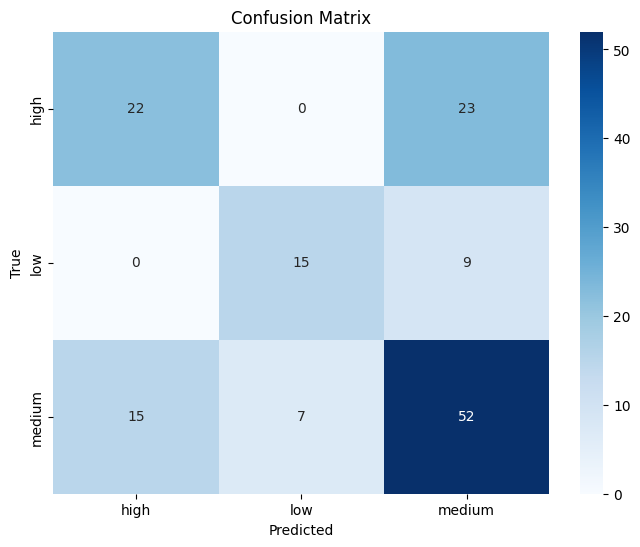

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

y_true = test_dataset['label']

# Assuming y_true and y_pred_new are already defined
# Encode labels
label_encoder = LabelEncoder()
y_true_encoded = label_encoder.fit_transform(y_true)
y_pred_new_encoded = label_encoder.transform(y_pred)

# Print classification report
print(classification_report(y_true_encoded, y_pred_new_encoded))

# Generate confusion matrix
cm = confusion_matrix(y_true_encoded, y_pred_new_encoded)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save_pretrained("severity_codellama")  
tokenizer.save_pretrained("severity_codellama")